# HM1 algorithms and hyperparameters tuning

# Algorithms 

SVM

k nn

Random forest

# Data

44 spam

1067 nasa https://www.openml.org/search?type=data&status=active&id=1067

1464 blood-transfusion-service-center

40701 churn

### Libraries

In [21]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import openml
from skopt import BayesSearchCV

### Data input

In [5]:
dataset = {}
data = {}
labels = {}
id = [44,1067,1464,40701]
for index in id:
    dataset[index] = openml.datasets.get_dataset(index)
    data[index], y, _, _ = dataset[index].get_data(dataset_format="dataframe")
    data[index] = data[index].replace('nan', np.nan) # not always needed
    labels[index] = list(data[index].columns.values)

c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\Users\AWeg\AppData\Local\Prog

### Preprocessing

In [6]:
def preprocess():
    num_pipeline = Pipeline(steps=[
        ('scale',MinMaxScaler())
    ])

    ### operacje dla kolumn kategorycznych
    cat_pipeline = Pipeline(steps=[
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))

    ])

    bool_pipeline = Pipeline(steps=[])

    col_trans = ColumnTransformer(transformers=[
        ('num_pipeline', num_pipeline, make_column_selector( dtype_exclude= np.object_)),
        ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_)),
        ],
    
        n_jobs=-1)
    
    model = Pipeline([('preprocessing', col_trans)])
    return model

In [7]:
data_prepared = {}
for index in id:
    datad = data[index]
    model =  preprocess()
    model.get_params()
    model.fit(datad)
    after_process = model.transform(datad)
    data_prepared[index] = pd.DataFrame(after_process, columns = labels[index])

### Data split

In [8]:
yColumnName = {44:"class",1067:"defects",1464:"Class",40701:"class"}
X = {}
y = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for index in id:

    X[index] = data_prepared[index].drop(yColumnName[index], axis=1)
    y[index] = data_prepared[index][yColumnName[index]]

    X_train[index],  X_test[index], y_train[index], y_test[index] = train_test_split(X[index], y[index])

## Grid search for tuning hyperparams

### RandomForestClassifier

In [9]:
pipeline = Pipeline([('RandomForestClassifier', RandomForestClassifier())])

In [10]:
pipeline.get_params()

{'memory': None,
 'steps': [('RandomForestClassifier', RandomForestClassifier())],
 'verbose': False,
 'RandomForestClassifier': RandomForestClassifier(),
 'RandomForestClassifier__bootstrap': True,
 'RandomForestClassifier__ccp_alpha': 0.0,
 'RandomForestClassifier__class_weight': None,
 'RandomForestClassifier__criterion': 'gini',
 'RandomForestClassifier__max_depth': None,
 'RandomForestClassifier__max_features': 'sqrt',
 'RandomForestClassifier__max_leaf_nodes': None,
 'RandomForestClassifier__max_samples': None,
 'RandomForestClassifier__min_impurity_decrease': 0.0,
 'RandomForestClassifier__min_samples_leaf': 1,
 'RandomForestClassifier__min_samples_split': 2,
 'RandomForestClassifier__min_weight_fraction_leaf': 0.0,
 'RandomForestClassifier__n_estimators': 100,
 'RandomForestClassifier__n_jobs': None,
 'RandomForestClassifier__oob_score': False,
 'RandomForestClassifier__random_state': None,
 'RandomForestClassifier__verbose': 0,
 'RandomForestClassifier__warm_start': False}

In [32]:
n_estimators_vector = np.linspace(10, 200, 10).astype(np.int_)
min_samples_leaf_vector = np.linspace(1, 50, 5).astype(np.int_)
random_state_vector = np.array([1]).astype(np.int_)
max_depth_vector =  np.linspace(10, 110, 11).astype(np.int_)
min_samples_split_vector = np.linspace(2, 10, 4).astype(np.int_)

In [33]:
grid_params = [{'RandomForestClassifier__n_estimators':n_estimators_vector,
                'RandomForestClassifier__min_samples_leaf':min_samples_leaf_vector,
                'RandomForestClassifier__random_state': random_state_vector, 
                'RandomForestClassifier__max_depth': max_depth_vector,
                'RandomForestClassifier__min_samples_split': min_samples_split_vector
                }]

In [13]:
best_hyperparams = []
score_for_best_hyperparams = {}
std_scores = []
all_scores = {}
# ps = PredefinedSplit(test_fold=1)

for index in id:
    gs_model_pipeline = GridSearchCV(estimator=pipeline,param_grid=grid_params,scoring='roc_auc',cv=2)
    gs_model_pipeline.fit(X[index], y[index])
    best_hyperparams.append(gs_model_pipeline.best_params_)

    #score for test data
    
    #score_for_best_hyperparams[index] = gs_model_pipeline.score(X_test[index], y_test[index])
    std_scores.append(gs_model_pipeline.cv_results_['mean_test_score'])
    all_scores[index] = gs_model_pipeline.cv_results_['mean_test_score']


In [14]:
best_hyperparams
gs_model_pipeline.cv_results_['mean_test_score']

array([0.91047991, 0.91248169, 0.9126562 , 0.91069353, 0.91414946,
       0.91356901, 0.88113938, 0.8859834 , 0.88675635, 0.88113938,
       0.8859834 , 0.88675635, 0.90515528, 0.91211651, 0.91313732,
       0.91124567, 0.9135487 , 0.91401073, 0.87712864, 0.8865822 ,
       0.88688213, 0.87712864, 0.8865822 , 0.88688213])

In [15]:
mean_std_vector   = np.mean(std_scores, axis =0)
minimum_std = np.max(mean_std_vector)
index_best = np.where(mean_std_vector == (minimum_std))[0][0]

In [16]:
for index in id:
    score_for_best_hyperparams[index] = np.max(all_scores[index])

In [37]:
score_for_best_hyperparams

{44: 0.9718765227191518,
 1067: 0.7897170354895005,
 1464: 0.7550463236743544,
 40701: 0.9141494628386202}

In [17]:
defaults = gs_model_pipeline.cv_results_['params'][index_best]

### Diff for defaults - best

In [18]:
score_for_default_hyperparams = {}
diff = {}

for index in id:
    diff[index] = score_for_best_hyperparams[index] - all_scores[index][index_best]
diff

{44: 0.011748206831924457,
 1067: 0.0018452874812975306,
 1464: 0.0,
 40701: 0.027567263306330192}

# Bayes Optimization

## BayesSearchCV

In [ ]:
# number of iters to change
iters = 50

bayes_params = grid_params
best_hyperparams_bayes = []
all_scores_bayes = {}

for index in [1067]:
    opt = BayesSearchCV(estimator=pipeline,search_spaces=bayes_params,scoring='roc_auc',cv=2, n_iter=iters, random_state=0)
    opt.fit(X[index], y[index])
    best_hyperparams_bayes.append(opt.best_params_)

    all_scores_bayes[index] = opt.cv_results_['mean_test_score']

In [36]:
best_hyperparams_bayes

[OrderedDict([('RandomForestClassifier__max_depth', 60),
              ('RandomForestClassifier__min_samples_leaf', 50),
              ('RandomForestClassifier__min_samples_split', 10),
              ('RandomForestClassifier__n_estimators', 52),
              ('RandomForestClassifier__random_state', 1)])]

In [41]:
all_scores_bayes[1067]

array([0.78845402, 0.78890371, 0.73792496, 0.78937883, 0.77519492,
       0.78880435, 0.78948198, 0.77805696, 0.78908255, 0.78403753,
       0.78908255, 0.78845402, 0.77683066, 0.78948198, 0.78818236,
       0.78971704, 0.7895074 , 0.78948198, 0.7918186 , 0.78955719,
       0.7837086 , 0.78863632, 0.78820866, 0.79029555, 0.7916024 ,
       0.78876909, 0.7918186 , 0.78819947, 0.7898549 , 0.7847876 ,
       0.78573656, 0.77896764, 0.7918186 , 0.7918186 , 0.78496731,
       0.78480677, 0.7918186 , 0.7918186 , 0.78534323, 0.78347987,
       0.78499491, 0.78414724, 0.7918186 , 0.77726385, 0.77163595,
       0.7918186 , 0.77433784, 0.7918186 , 0.7918186 , 0.76532762])

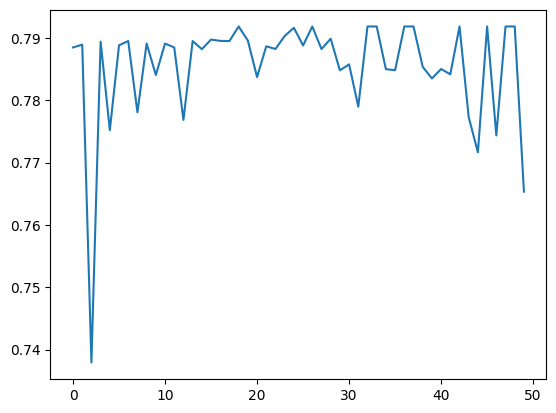

In [42]:
import matplotlib.pyplot as plt

plt.plot(all_scores_bayes[1067])

## gp_mini - REOMOVEEEE

In [16]:
from sklearn.ensemble import RandomForestClassifier


### definition of model

def rf_to_opt(params,X_train=X_train[44], y_train=y_train[44], X_test=X_test[44], y_test=y_test[44]):
    print(params)
    model_pipeline = Pipeline([('model', RandomForestClassifier(n_estimators=np.int64(params[0]), min_samples_leaf = params[1], max_depth=np.int64(params[2]),min_samples_split= np.int64(params[3])))])

    
    model_pipeline.fit(X_train, y_train)
    return model_pipeline.score(X_test, y_test)



bounds = np.array([(np.min(n_estimators_vector), np.max(n_estimators_vector)), ([np.min(min_samples_leaf_vector), np.max(min_samples_leaf_vector)]), ([np.min(max_depth_vector), np.max(max_depth_vector)]), ([np.min(min_samples_split_vector), np.max(min_samples_split_vector)])]) # HERE CHANGE FOR MORE PARAMS

In [ ]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

np.int = np.int_


noise = 0.2
# Use custom kernel and estimator to match previous example

m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(lambda x: -rf_to_opt(params=x), 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=1000,         # number of iterations
                )

r.values
## Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

In [18]:
import numpy as np    
X = r.x_iters
Y = -r.func_vals
X = np.linspace(1, len(X), len(X)).astype(int)


NameError: name 'r' is not defined

In [ ]:
Y_maxining = []
max = 0
for z in Y: 
    if(z>max):
        max = z
    Y_maxining.append(max)

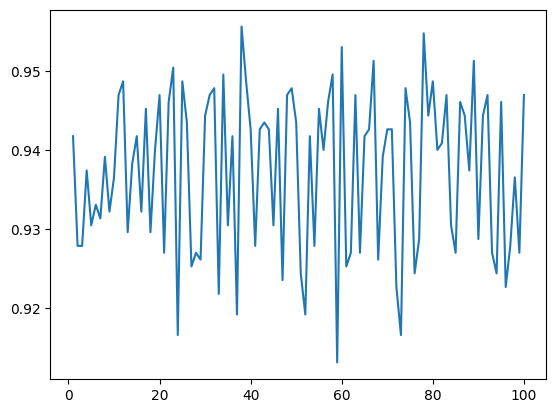

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sorted(X), Y)

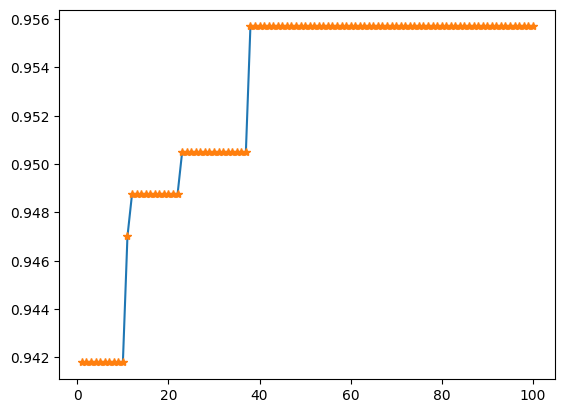

In [ ]:
plt.plot(sorted(X), Y_maxining)
plt.plot(sorted(X), Y_maxining, '*')

# Defaults - BO

In [ ]:
minimum_std